## Training `multiclass_model` on ["Humanface_of_various_age_groups" dataset](https://www.kaggle.com/datasets/neeeeeear/humanface-of-various-age-groups/data) to enhance live image representation & analyze capacity on gender and age

#### <mark><strong>Note</strong>: The observed performance of the model is unexpectedly high, which could indicate either exceptional model efficacy or potential issues within the evaluation code. Further investigation is recommended to validate these results.</mark>

In [1]:
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import os
from PIL import Image
import json
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm

### Goal: Enhance Live Image Representation

1. download & preprocess images in a new dataset, which only includes live images of Asian people grouped by age and gender.
2. create a mixed dataset by combining the new live images with the spoof images in the original dataset.
3. train.
4. eval & analyze how the model performs on classifying lives images depending on gender and age.

In [3]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        
model = CNNModel()
model.load_state_dict(torch.load('multiclass_cnn.pth', map_location=torch.device('cpu')))
model.eval()

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=200704, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=5, bias=True)
)

### Prepare images from the new age dataset
Make sure to download the dataset from: https://www.kaggle.com/datasets/neeeeeear/humanface-of-various-age-groups/data?select=README.txt

In [3]:
def preprocess_image(image_path, output_size, save=False, save_path=None):
    with Image.open(image_path) as img:
        # Pad the image to a square, evenly
        max_side = max(img.size)
        left = (max_side - img.size[0]) // 2
        top = (max_side - img.size[1]) // 2
        right = max_side - img.size[0] - left
        bottom = max_side - img.size[1] - top
        img = img.crop((-left, -top, img.size[0] + right, img.size[1] + bottom))
        img = img.resize(output_size, Image.LANCZOS)

        if save:
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            img.save(save_path)

In [5]:
def process_directory(directory, output_directory, output_size=(224, 224)):
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(subdir, file)
                relative_path = os.path.relpath(subdir, directory)
                output_path = os.path.join(output_directory, relative_path, file)
                preprocess_image(file_path, output_size, save=True, save_path=output_path)
                print(f"Processed and saved: {output_path}")

In [8]:
source_dir = "age_dataset/Humanface"
output_dir = "preprocessed_age_dataset" 
process_directory(source_dir, output_dir)

Processed and saved: preprocessed_age_dataset/Male/11-20/3025-Male-18.png
Processed and saved: preprocessed_age_dataset/Male/11-20/2142-Male-18.png
Processed and saved: preprocessed_age_dataset/Male/11-20/2219-Male-18.png
Processed and saved: preprocessed_age_dataset/Male/11-20/0528-Male-20.png
Processed and saved: preprocessed_age_dataset/Male/11-20/2198-Male-19.png
Processed and saved: preprocessed_age_dataset/Male/11-20/9346-Male-19.png
Processed and saved: preprocessed_age_dataset/Male/11-20/0092-Male-15.png
Processed and saved: preprocessed_age_dataset/Male/11-20/1221-Male-20.png
Processed and saved: preprocessed_age_dataset/Male/11-20/0768-Male-20.png
Processed and saved: preprocessed_age_dataset/Male/11-20/2560-Male-18.png
Processed and saved: preprocessed_age_dataset/Male/11-20/2722-Male-13.png
Processed and saved: preprocessed_age_dataset/Male/11-20/1290-Male-17.png
Processed and saved: preprocessed_age_dataset/Male/11-20/1771-Male-19.png
Processed and saved: preprocessed_age_

In [ ]:
# Note: images in the Age Dataset named in the following format:  "Number-Gender-Age.jpg"

In [4]:
!ls

README.md                   models.ipynb
Untitled.ipynb              multiclass_cnn.pth
age_dataset                 multiclass_models.ipynb
best_model_recall.pth       organized_data
data                        preprocessed_age_dataset
file_organizer.ipynb        preprocessed_data
hw2                         split_data
image_pad_scale_local.ipynb train_label.json


### Prepare images from the original dataset
Make sure to have our original train dataset! You can download it from: https://drive.google.com/uc?id=1P-ypjfLTZsEpBSyMdzoeThlWd-l1a5rN <br>
Also be sure to have `train_label.json`

In [5]:
# reference Lara's multiclass models notebook if needed.

### `CombinedDataset` class
Now combining spoof images from the original dataset & images from the new dataset to create a new dataset...

In [106]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os
import json

class CombinedDataset(Dataset):
    def __init__(self, live_paths, spoof_paths, spoof_label_file, transform=None):
        """
        Args:
            live_paths (list): List of paths to live images.
            spoof_paths (list): List of paths to spoof images.
            spoof_label_file (str): Path to JSON file with labels for spoof images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.transform = transform
        
        # Load labels for spoof images
        with open(spoof_label_file, 'r') as f:
            self.spoof_labels = json.load(f)

        # Initialize image paths and labels
        self.image_paths = live_paths + spoof_paths
        
        # Assign labels: 0 for live, and labels from the JSON file for spoofs
        self.labels = [0] * len(live_paths) + [self.spoof_labels.get(os.path.basename(path).replace('.jpg', '.png'), 1) for path in spoof_paths]

        # Extract metadata for live images and assign None for spoof images
        self.metadata = [{'age': None, 'gender': None} if label != 0 else self.extract_metadata(path) for path, label in zip(self.image_paths, self.labels)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[index]
        metadata = self.metadata[index]

        if self.transform:
            image = self.transform(image)

        return image, label, metadata

    @staticmethod
    def extract_metadata(path):
        filename = os.path.basename(path)
        parts = filename.split('-')
        # Assuming filename format is ID-Gender-Age.png for live images
        if len(parts) == 3:
            gender = parts[1]
            age = parts[2].split('.')[0]  # Remove file extension and get age
            return {'gender': gender, 'age': age}
        return {'gender': None, 'age': None}

In [107]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [108]:
def load_image_paths(directory):
    """
    Load all image paths from a given directory.
    
    Args:
        directory (str): The path to the directory from which to load images.
        
    Returns:
        list: A list of paths to the images in the directory.
    """
    image_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(root, file))
    return image_paths

In [109]:
live_image_paths = load_image_paths('preprocessed_age_dataset')
spoof_image_paths = load_image_paths('preprocessed_data/spoof')

# Print the first few paths to verify
print("Live Image Paths:")
print(live_image_paths[:5])  # Print the first 5 paths
print()
print("Spoof Image Paths:")
print(spoof_image_paths[:5])  # Print the first 5 paths
print()

# Iterate over the paths and print each one
print("Live Image Paths:")
for path in live_image_paths[:5]:  # Iterate over the first 5 paths
    print(path)
print()

print("Spoof Image Paths:")
for path in spoof_image_paths[:5]:  # Iterate over the first 5 paths
    print(path)

Live Image Paths:
['preprocessed_age_dataset/Male/11-20/3025-Male-18.png', 'preprocessed_age_dataset/Male/11-20/2142-Male-18.png', 'preprocessed_age_dataset/Male/11-20/2219-Male-18.png', 'preprocessed_age_dataset/Male/11-20/0528-Male-20.png', 'preprocessed_age_dataset/Male/11-20/2198-Male-19.png']

Spoof Image Paths:
['preprocessed_data/spoof/560874.png', 'preprocessed_data/spoof/526821.png', 'preprocessed_data/spoof/518717.png', 'preprocessed_data/spoof/517424.png', 'preprocessed_data/spoof/551471.png']

Live Image Paths:
preprocessed_age_dataset/Male/11-20/3025-Male-18.png
preprocessed_age_dataset/Male/11-20/2142-Male-18.png
preprocessed_age_dataset/Male/11-20/2219-Male-18.png
preprocessed_age_dataset/Male/11-20/0528-Male-20.png
preprocessed_age_dataset/Male/11-20/2198-Male-19.png

Spoof Image Paths:
preprocessed_data/spoof/560874.png
preprocessed_data/spoof/526821.png
preprocessed_data/spoof/518717.png
preprocessed_data/spoof/517424.png
preprocessed_data/spoof/551471.png


In [110]:
train_live_paths, test_live_paths = train_test_split(live_image_paths, test_size=0.2, random_state=42)
train_spoof_paths, test_spoof_paths = train_test_split(spoof_image_paths, test_size=0.2, random_state=42)

# Creating datasets for training and testing
train_dataset = CombinedDataset(
    live_paths=train_live_paths,
    spoof_paths=train_spoof_paths,
    spoof_label_file='train_label.json',
    transform=transform
)

test_dataset = CombinedDataset(
    live_paths=test_live_paths,
    spoof_paths=test_spoof_paths,
    spoof_label_file='train_label.json',
    transform=transform
)

In [111]:
# Check some samples from the train dataset
print("Train Dataset Samples:")
for i in range(5):  # Print the first 5 samples
    sample = train_dataset[i]
    image, label, metadata = sample
    print(f"Sample {i + 1}:")
    print(f"Image shape: {image.shape}")
    print(f"Label: {label}")
    print(f"Metadata: {metadata}")

print()

# Check some samples from the test dataset
print("Test Dataset Samples:")
for i in range(5):  # Print the first 5 samples
    sample = test_dataset[i]
    image, label, metadata = sample
    print(f"Sample {i + 1}:")
    print(f"Image shape: {image.shape}")
    print(f"Label: {label}")
    print(f"Metadata: {metadata}")

Train Dataset Samples:
Sample 1:
Image shape: torch.Size([3, 224, 224])
Label: 0
Metadata: {'gender': 'Male', 'age': '18'}
Sample 2:
Image shape: torch.Size([3, 224, 224])
Label: 0
Metadata: {'gender': 'Female', 'age': '15'}
Sample 3:
Image shape: torch.Size([3, 224, 224])
Label: 0
Metadata: {'gender': 'Female', 'age': '4'}
Sample 4:
Image shape: torch.Size([3, 224, 224])
Label: 0
Metadata: {'gender': 'Female', 'age': '11'}
Sample 5:
Image shape: torch.Size([3, 224, 224])
Label: 0
Metadata: {'gender': 'Female', 'age': '68'}

Test Dataset Samples:
Sample 1:
Image shape: torch.Size([3, 224, 224])
Label: 0
Metadata: {'gender': 'Female', 'age': '19'}
Sample 2:
Image shape: torch.Size([3, 224, 224])
Label: 0
Metadata: {'gender': 'Female', 'age': '31'}
Sample 3:
Image shape: torch.Size([3, 224, 224])
Label: 0
Metadata: {'gender': 'Female', 'age': '32'}
Sample 4:
Image shape: torch.Size([3, 224, 224])
Label: 0
Metadata: {'gender': 'Female', 'age': '3'}
Sample 5:
Image shape: torch.Size([3, 22

In [112]:
def collate_fn(batch):
    images = [item[0] for item in batch]  # Extract images
    labels = [item[1] for item in batch]  # Extract labels
    metadata = [item[2] for item in batch]  # Extract metadata

    # Convert images to tensors and stack them into a batch tensor
    images = torch.stack(images)

    # Convert labels to tensors
    labels = torch.tensor(labels)

    return images, labels, metadata

In [113]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

### Data loaders

In [114]:
print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in test_loader: {len(test_loader)}")

Number of batches in train_loader: 1206
Number of batches in test_loader: 302


In [115]:
# Print the first batch data from the DataLoader
print(next(iter(train_loader)))

(tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, 

### Testing on small batches, because the model was trainining with 0.000 loss...

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


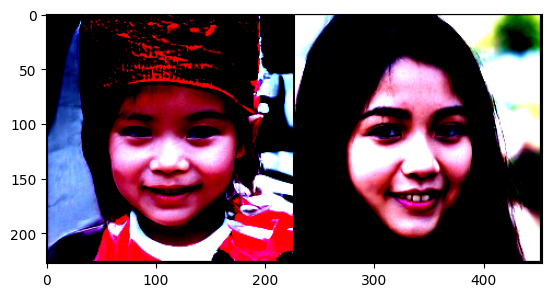

Labels: tensor([0, 0])
Metadata: [{'gender': 'Female', 'age': '4'}, {'gender': 'Female', 'age': '15'}]


In [128]:
import matplotlib.pyplot as plt
import torchvision

dataiter = iter(small_train_loader)
images, labels, metadata = next(dataiter) 

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))

# Print labels
print('Labels:', labels)

# Optionally print metadata
print('Metadata:', metadata)

In [129]:
small_train_dataset = torch.utils.data.Subset(train_dataset, indices=[0, 1, 2])  # Take first 3 samples
small_test_dataset = torch.utils.data.Subset(test_dataset, indices=[0, 1, 2])  # Take first 3 samples

small_train_loader = DataLoader(small_train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
small_test_loader = DataLoader(small_test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

In [130]:
model.train()
for epoch in range(num_epochs):
    for i, (images, labels, _) in enumerate(small_train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if i % 2 == 0:  # Print the outputs periodically, e.g., every batch or every few batches
            print(f"Batch {i} Outputs:\n{outputs}\n")
            print(f"Batch {i} Labels:\n{labels}\n")

        print(f"Epoch [{epoch+1}/{num_epochs}], Batch {i}, Loss: {loss.item():.4f}")

Batch 0 Outputs:
tensor([[ 19.1673, -11.1967, -53.2230, -43.9343, -52.8159],
        [ 19.8164,  -8.1227, -63.3523, -50.4997, -60.9266]],
       grad_fn=<AddmmBackward0>)

Batch 0 Labels:
tensor([0, 0])

Epoch [1/10], Batch 0, Loss: 0.0000
Epoch [1/10], Batch 1, Loss: 0.0000
Batch 0 Outputs:
tensor([[ 19.1675, -11.1971, -53.2237, -43.9348, -52.8166],
        [ 22.6730, -16.5934, -32.4553, -29.4398, -33.9102]],
       grad_fn=<AddmmBackward0>)

Batch 0 Labels:
tensor([0, 0])

Epoch [2/10], Batch 0, Loss: 0.0000
Epoch [2/10], Batch 1, Loss: 0.0000
Batch 0 Outputs:
tensor([[ 19.8174,  -8.1241, -63.3530, -50.5006, -60.9272],
        [ 22.6733, -16.5938, -32.4558, -29.4402, -33.9106]],
       grad_fn=<AddmmBackward0>)

Batch 0 Labels:
tensor([0, 0])

Epoch [3/10], Batch 0, Loss: 0.0000
Epoch [3/10], Batch 1, Loss: 0.0000
Batch 0 Outputs:
tensor([[ 19.1679, -11.1979, -53.2252, -43.9359, -52.8181],
        [ 22.6736, -16.5942, -32.4562, -29.4406, -33.9111]],
       grad_fn=<AddmmBackward0>)



In [131]:
probabilities = torch.softmax(outputs, dim=1)
predicted_classes = torch.argmax(probabilities, dim=1)
print(f"Predicted classes: {predicted_classes}")
print(f"Actual labels: {labels}")

Predicted classes: tensor([0])
Actual labels: tensor([0])


In [132]:
probabilities = torch.softmax(outputs, dim=1)
print(f"Probabilities: {probabilities}")

Probabilities: tensor([[1.0000e+00, 7.2680e-13, 7.5322e-37, 2.8728e-31, 8.5184e-36]],
       grad_fn=<SoftmaxBackward0>)


### Training Loop

In [138]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

In [135]:
# from sklearn.metrics import recall_score, accuracy_score, roc_auc_score, f1_score

# model.train()
# for epoch in range(num_epochs):
#     loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
#     for images, labels, _ in loop:
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         loop.set_postfix(loss=loss.item())
#     loop.close()

#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Will be undersampling spoof images to mitigate the class imbalance issue. Every training epoch resulted in 0.0000 loss. 

#### Undersampling

In [136]:
import numpy as np
from torch.utils.data import Subset

live_indices = [i for i, (_, label, _) in enumerate(train_dataset) if label == 0]
spoof_indices = [i for i, (_, label, _) in enumerate(train_dataset) if label != 0]

# Undersample the spoof indices
undersampled_spoof_indices = np.random.choice(spoof_indices, size=len(live_indices), replace=False)

# Combine live and undersampled spoof indices
balanced_indices = np.concatenate([live_indices, undersampled_spoof_indices])

balanced_train_dataset = Subset(train_dataset, balanced_indices)
balanced_train_loader = DataLoader(balanced_train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

In [139]:
from sklearn.metrics import recall_score, accuracy_score, roc_auc_score, f1_score

model.train()
for epoch in range(num_epochs):
    loop = tqdm(balanced_train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for images, labels, _ in loop:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item())
    loop.close()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/10], Loss: 0.0000


Epoch [2/10], Loss: 0.3324


Epoch [3/10], Loss: 0.0000


Epoch [4/10], Loss: 0.0000


Epoch [5/10], Loss: 0.0000


Epoch [6/10], Loss: 0.0000


Epoch [7/10], Loss: 0.0000


Epoch [8/10], Loss: 0.0000


Epoch [9/10], Loss: 0.0000


Epoch [10/10], Loss: 0.0000


### Evaluation Loop

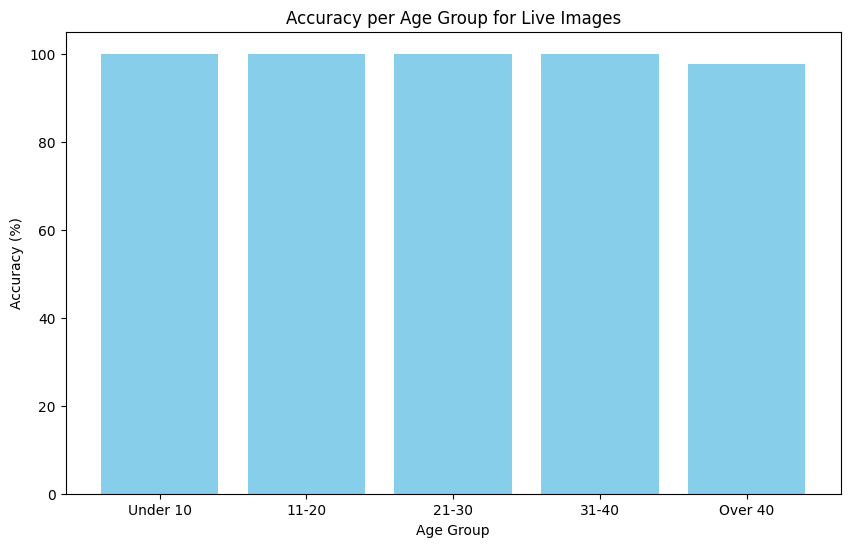

In [143]:
def assign_to_bin(age):
    if age < 10:
        return "Under 10"
    elif age <= 20:
        return "11-20"
    elif age <= 30:
        return "21-30"
    elif age <= 40:
        return "31-40"
    else:
        return "Over 40"

# Initialize a dictionary to hold the aggregated data
bin_accuracy = {
    "Under 10": {'correct': 0, 'total': 0},
    "11-20": {'correct': 0, 'total': 0},
    "21-30": {'correct': 0, 'total': 0},
    "31-40": {'correct': 0, 'total': 0},
    "Over 40": {'correct': 0, 'total': 0},
}

with torch.no_grad():
    for images, labels, metadata in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for i, (pred, label) in enumerate(zip(predicted, labels)):
            if label == 0:  # Focusing on live images
                age_group = assign_to_bin(int(metadata[i]['age']))
                bin_accuracy[age_group]['total'] += 1
                if pred == label:
                    bin_accuracy[age_group]['correct'] += 1

# Now, calculate and plot the accuracy for each bin
ages = list(bin_accuracy.keys())
accuracies = [100 * stats['correct'] / max(stats['total'], 1) for stats in bin_accuracy.values()]  # max to avoid division by zero

plt.figure(figsize=(10, 6))
plt.bar(ages, accuracies, color='skyblue')
plt.xlabel('Age Group')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Age Group for Live Images')
plt.show()

In [144]:
# Save the model
torch.save(model.state_dict(), 'enhanced_multiclass_model.pth')

print("Model saved successfully.")

Model saved successfully.
